<center>
<h2><b>
Semi-supervised Node Classification using Graph Convolutional Networks (GCN)
</center>

<h3>
<u>Objective</u>: A graph where few nodes are labeled and we need to find rest of the node labeles by utilizing the available node features and information about the graph structure (like adjacency matrix).

<h3>
<u>Real-world Scenario</u>: The citation datasets are undirected, unweighted graphs where nodes denote academic publications and edges represent the citations among the papers. Every node belongs to one of the academic subjects. Under semi-supervised settings, few labeled nodes are available for training. Our target is to classifiy rest of the nodes by exploiting the graph-structure.

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# installing pytorch-geomtric packages 
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


1.12.1+cu113
     |████████████████████████████████| 7.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 3.2 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn
from torch_geometric.datasets import Planetoid
import torch_geometric.utils 
from torch_geometric.transforms import NormalizeFeatures

from sklearn.manifold import TSNE 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# load Citation datasets like Cora, Citeseer, or Pubmed
dataset = Planetoid(root='data/Planetoid', name='Cora', transform = NormalizeFeatures())

In [4]:
# selecting data from the list of the graph datasets. but in thisd case only one graph is available.
data = dataset[0]

In [18]:
# print(data.edge_index[:10])
print(data.test_mask.sum())

tensor(1000)


In [5]:
# helper function to visualize node embeddings
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# GCN message propagation rule

Let $A$ is the adjacency matrix and $X$ is the feature matrix then update node representations will be 

<center>
<h2>
$X^{l+1} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} X^{l} W^{l})$
</center>

where $\tilde{A} = A + I$, $\tilde{D}= D + I$, $X^{l}$ denotes feature matrix at $l^{th}$ layer and $W^{l}$ is the trainable weight matrix of the $l^{th}$ layer.

# Graph Laplacian

$L = D - A$ where $D$ is the degree matrix 

Symmetrically normalized graph laplacian is $D^{-\frac{1}{2}} L D^{-\frac{1}{2}}$ 

In [6]:
import math
import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

# define a single graph convolution layer
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            # self.register_parameter('bias', None)
            pass
        self.reset_parameters()

    # initializing weights 
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # (X, W)
        support = torch.mm(input, self.weight) 
        # (A, XW)
        output = torch.mm(adj, support)

        if self.bias is not None:
            return output + self.bias
        else:
            return output

<h1> Message propagation in a two-layered GCN

<center>
$ H = Softmax(\tilde{A}(ReLU(\tilde{A} X W^{(0)})) W^{(1)})$
</center>

where $W^{(0)}, W^{(1)}$ are two trainalbe weight matrices, $X$ is the feature matrix.

In [7]:
# A two-layered gcn will be used

import torch.nn as nn
import torch.nn.functional as F

# building GCN model with 2 graph convolution layers
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        # f(X, A)
        # first gcn layer 
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        # second gcn layer
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


In [8]:
# helper function to symmetrically normaqlize adjacency matrix
def norm_adj(edge_index):

  # edge index to adj matrix construction
  adj_matrix = torch.zeros(data.num_nodes, data.num_nodes)
  # edge_index stores edge list 
  # shape (2, |E|) where |E| is the number of edges in the graph

  for e in range(data.num_edges):
    src = data.edge_index[0][e]
    tgt = data.edge_index[1][e]
    adj_matrix[src][tgt] = 1

  # normalization 
  adj_matrix += torch.eye(data.num_nodes)
  degrees = torch.sum(adj_matrix, dim = 1)
  degree_matrix = torch.diag(1 / torch.sqrt(degrees))
  norm_adj = torch.mm(degree_matrix, adj_matrix)
  norm_adj = torch.mm(norm_adj, degree_matrix)

  return norm_adj
  

In [9]:
# normalizing adjacency matrix
adj = norm_adj(data.edge_index)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


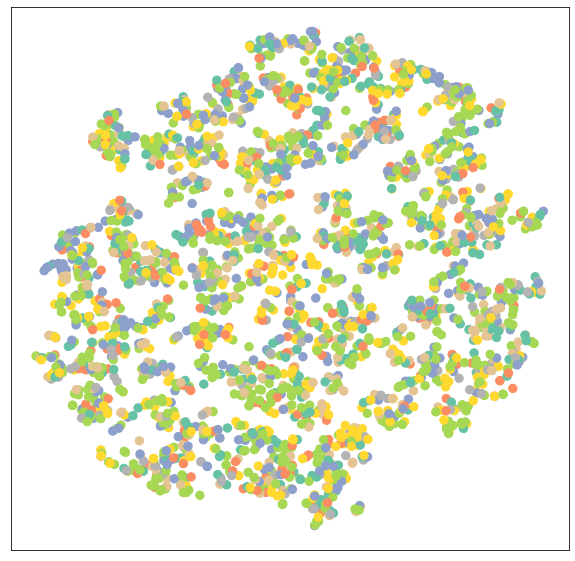

In [10]:
# Embedding visualization before training of Cora dataset

model = GCN(dataset.num_features, 16, dataset.num_classes, 0.60)

out = model(data.x, adj)
visualize(out, color=data.y)

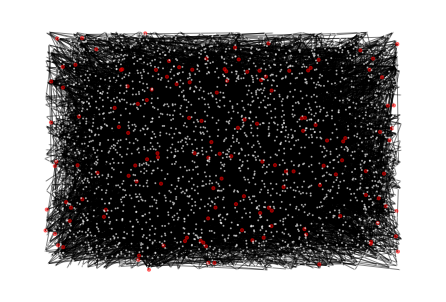

In [11]:
G = nx.Graph()

color_map = []
node_size = []
for n in range(data.num_nodes):
    if data.train_mask[n] == True:
        color_map.append('red')
        node_size.append(10)
    else:
        color_map.append('white')
        node_size.append(1)

e = [(data.edge_index[0][i].item(), data.edge_index[1][i].item()) for i  in range(data.num_edges)]
# print(e)
G.add_edges_from(e)

nx.draw_random(G, with_labels = False, node_size = node_size, node_color = color_map, alpha = 0.5)
plt.show()

Epoch: 000, Loss: 1.9720, Test Accuracy: 0.1150
Epoch: 001, Loss: 1.9615, Test Accuracy: 0.1200
Epoch: 002, Loss: 1.9541, Test Accuracy: 0.1290
Epoch: 003, Loss: 1.9521, Test Accuracy: 0.1400
Epoch: 004, Loss: 1.9506, Test Accuracy: 0.1480
Epoch: 005, Loss: 1.9367, Test Accuracy: 0.1500
Epoch: 006, Loss: 1.9299, Test Accuracy: 0.1560
Epoch: 007, Loss: 1.9322, Test Accuracy: 0.1560
Epoch: 008, Loss: 1.9282, Test Accuracy: 0.1600
Epoch: 009, Loss: 1.9267, Test Accuracy: 0.1640
Epoch: 010, Loss: 1.9106, Test Accuracy: 0.1690
Epoch: 011, Loss: 1.9069, Test Accuracy: 0.1770
Epoch: 012, Loss: 1.9104, Test Accuracy: 0.2280
Epoch: 013, Loss: 1.8932, Test Accuracy: 0.2690
Epoch: 014, Loss: 1.8977, Test Accuracy: 0.2860
Epoch: 015, Loss: 1.8845, Test Accuracy: 0.3190
Epoch: 016, Loss: 1.8809, Test Accuracy: 0.3340
Epoch: 017, Loss: 1.8889, Test Accuracy: 0.3580
Epoch: 018, Loss: 1.8655, Test Accuracy: 0.3870
Epoch: 019, Loss: 1.8662, Test Accuracy: 0.4190
Epoch: 020, Loss: 1.8493, Test Accuracy:

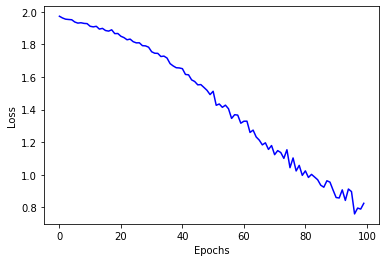

In [19]:
model = GCN(dataset.num_features, 16, dataset.num_classes, 0.60)
num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

train_loss = []

# train
def train():
      model.train()
      optimizer.zero_grad() 
      out = model(data.x, adj) 
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()  
      return loss

# test
def test():
      model.eval()
      out = model(data.x, adj)
      pred = out.argmax(dim=1)  
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

# training loop
for epoch in range(num_epochs):
    loss = train()
    test_acc = test()
    train_loss.append(loss.item())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

# plot training loss vs epochs
plt.plot(np.arange(num_epochs), train_loss, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
# evaluation stage
model.eval()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8070


torch.Size([2708, 7])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


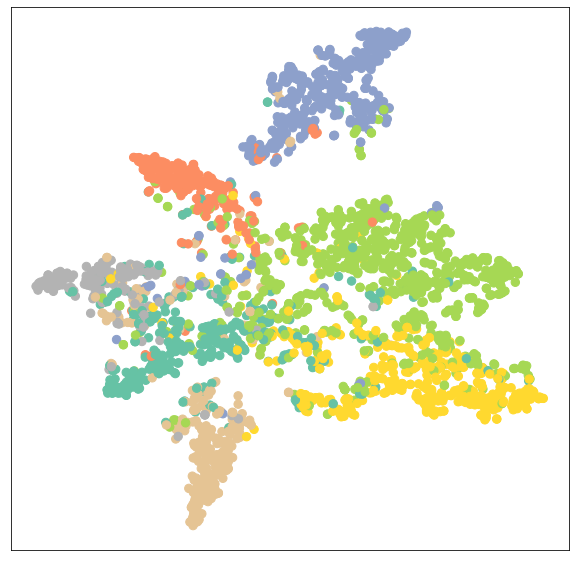

In [21]:
model.eval()

out = model(data.x, adj)
print(out.shape)

# visualizing node embeddings after training
visualize(out, color=data.y)

In [22]:
# Animation to visuaize node embeddings

!wget 'https://github.com/kushalbose92/GCN/blob/main/visuals/node_embedding_by_gcn.gif'

--2022-10-14 10:15:39--  https://github.com/kushalbose92/GCN/blob/main/visuals/node_embedding_by_gcn.gif
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘node_embedding_by_gcn.gif’

node_embedding_by_g     [ <=>                ] 133.50K  --.-KB/s    in 0.04s   

2022-10-14 10:15:39 (3.53 MB/s) - ‘node_embedding_by_gcn.gif’ saved [136704]

